In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import gzip
import pandas
import h5py
import numpy as np
from __future__ import print_function
import argparse
import os
import h5py
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn import model_selection

In [98]:
#pred_part

In [99]:
import numpy as np
import pandas as pd

In [100]:
data_test=pd.read_excel("D:\download\property_smiles.xlsx")

In [101]:
data_test=data_test[0:80000]

In [240]:
# initiate an instance of the MolecularVAE
pretrained_vae = torch.load('C:/Users/IKKASENSEI/Desktop/2024/ai/net_finish/pre_vae_finih.pt')
# load the pre-trained model (we provide this)
pretrained_vae.load_state_dict(torch.load("C:/Users/IKKASENSEI/Desktop/2024/ai/net_finish/pre_vae_params_finish.pt"))

<All keys matched successfully>

In [241]:
data_pre=data_test[['complexity','complexity','xlogp','heavycnt','hbonddonor','hbondacc','rotbonds','canonicalsmiles']].sample(20000).values
data_pre[1][7]

'C(CO)N(CCO)CCO.C(C(C(C(C(C(=O)O)O)O)O)O)O'

In [242]:
#filter
data_pre_filter=[]
for i in range(len(data_pre)):
    if len(data_pre[i][7])<80:
        if len(data_pre[i][7])>8:
            data_pre_filter.append(data_pre[i])
data_pre_filter=np.array(data_pre_filter)

In [243]:
data_pre_filter_label=data_pre_filter[:,0:-1]
data_pre_filter_smiles=data_pre_filter[:,-1]


In [244]:
sequences_pre=[]
for i in range(len(data_pre_filter_smiles)):
  sequences_pre.append(token.texts_to_matrix(data_pre_filter_smiles[i]))
sequences_120_pre=[]
for i in range(len(data_pre_filter_smiles)):
  sequences_120_pre.append(np.pad(sequences_pre[i],[(0,120-len(sequences_pre[i])),(0,0)],'constant',constant_values=(0)))

In [245]:
sequences_120_pre=torch.FloatTensor(np.array(sequences_120_pre)).to(device)
z_m,z_l=pretrained_vae.encode(sequences_120_pre)

C:\Users\IKKASENSEI\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 73.46 GiB. GPU  (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:924.)
  return F.conv1d(input, weight, bias, self.stride,
C:\Users\IKKASENSEI\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


In [246]:
z_l.shape

torch.Size([19441, 310])

In [247]:
z_m_l=torch.cat((z_m.detach(),z_l.detach()),1)
X=np.array(torch.Tensor.cpu(z_m_l))

In [248]:
y=(np.array(data_pre_filter_label)).astype(float)

In [249]:
y=np.nan_to_num(y)

In [188]:
#data=pd.read_csv(r'C:\Users\IKKASENSEI\Desktop\2024\ai\data.csv',header=None)

In [489]:
y[7141]

array([130. , 130. ,   2.1,  12. ,   0. ,   2. ,   4. ])

In [191]:
#data = data.fillna(0)

In [192]:
#y=data.iloc[:,0:7].values
#X=data.iloc[:,7:].values

In [193]:
from sklearn.model_selection import train_test_split

In [250]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaler=scaler.transform(X)

In [251]:
X_train,X_test,y_train,y_test=train_test_split(X_scaler,y,test_size=0.2)

In [252]:
import h5py
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
device = "cuda" if torch.cuda.is_available() else "cpu"
print("GPU available: ", torch.cuda.is_available())

GPU available:  True


In [253]:
X_train=torch.Tensor(X_train).to(torch.float32)
y_train=torch.Tensor(y_train).to(torch.float32)
X_test=torch.Tensor(X_test).to(torch.float32)
y_test=torch.Tensor(y_test).to(torch.float32)

In [330]:
model_pre=nn.Sequential(
    nn.Linear(620,258),

    nn.ReLU(),
    nn.Linear(258,7),

).to(device)
print(model_pre)
loss_fn=nn.MSELoss()
learning_rate=0.001
optimizer_pre=torch.optim.Adam(model_pre.parameters(),lr=learning_rate)

Sequential(
  (0): Linear(in_features=620, out_features=258, bias=True)
  (1): ReLU()
  (2): Linear(in_features=258, out_features=7, bias=True)
)


In [331]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None, target_transform=None):
        self.data = data
        self.target = target
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        if self.transform:
            x = self.transform(x)

        y = self.target[index]
        if self.target_transform:
            y = self.target_transform(y)

        return x, y

In [332]:
train=MyDataset(X_train,y_train)
test=MyDataset(X_test,y_test)

In [333]:
train_loader_pre=DataLoader(dataset=train,batch_size=250,shuffle=True)

In [334]:
test_loader_pre=DataLoader(dataset=test,batch_size=250,shuffle=True)

In [335]:
from sklearn.metrics import r2_score

In [336]:
def train_pre(dataloader,model,loss_fn,optimizer):
  size=len(dataloader.dataset)
  model.train()
  for batch, (X,y) in enumerate(dataloader):
    X,y=X.to(device),y.to(device)

    pred=model(X)
    loss=loss_fn(pred,y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 300 == 0:
      loss,correct=loss.item(),(batch+1)*len(X)
      print(f"loss:{loss:>7f}[{correct:>5d}/{size:>5d}]")
  return loss.detach()
def test_pre(dataloader,model,loss_fn):
  size=len(dataloader.dataset)
  num_batches=len(dataloader)
  model.eval()
  test_loss,correct=0,0
  with torch.no_grad():
    for X,y in dataloader:
      X,y=X.to(device),y.to(device)
      pred=model(X)
      test_loss+=loss_fn(pred,y).item()
      correct+=r2_score(torch.Tensor.cpu(pred),torch.Tensor.cpu(y))
  test_loss/=num_batches
  correct=correct/size
  print(f"Test Error:\n Accurancy:{(correct):>0.1f},Avg loss:{test_loss:>8f}\n")
  return test_loss           

In [337]:
torch.manual_seed(114514)
epochs=200
loss_train=[]
loss_test=[]
for t in range(epochs):
  print(f"Epoch{t+1}\n")
  loss_train.append(train_pre(train_loader_pre,model_pre,loss_fn,optimizer_pre))
  loss_test.append(test_pre(test_loader_pre,model_pre,loss_fn))

Epoch1

loss:37747.710938[  250/15552]
Test Error:
 Accurancy:-0.0,Avg loss:24745.535522

Epoch2

loss:25376.294922[  250/15552]
Test Error:
 Accurancy:0.0,Avg loss:3676.057770

Epoch3

loss:3337.389648[  250/15552]
Test Error:
 Accurancy:0.0,Avg loss:1722.638832

Epoch4

loss:1824.295532[  250/15552]
Test Error:
 Accurancy:0.0,Avg loss:1389.852486

Epoch5

loss:1403.694214[  250/15552]
Test Error:
 Accurancy:0.0,Avg loss:1222.320034

Epoch6

loss:1160.593750[  250/15552]
Test Error:
 Accurancy:0.0,Avg loss:1081.678425

Epoch7

loss:889.490540[  250/15552]
Test Error:
 Accurancy:0.0,Avg loss:1029.223732

Epoch8

loss:833.189148[  250/15552]
Test Error:
 Accurancy:0.0,Avg loss:963.311737

Epoch9

loss:988.507446[  250/15552]
Test Error:
 Accurancy:0.0,Avg loss:935.118126

Epoch10

loss:864.478516[  250/15552]
Test Error:
 Accurancy:0.0,Avg loss:897.974522

Epoch11

loss:964.752014[  250/15552]
Test Error:
 Accurancy:0.0,Avg loss:865.850807

Epoch12

loss:751.671204[  250/15552]
Test Err

In [362]:
#transfer learning
import torch.nn.init as init
for param in model_pre.parameters():
    param.requires_grad=False
model_d=nn.Sequential(
    nn.Linear(1,620,bias=False),
    model_pre
).to(device)
print(model_d)
def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)

model_d.apply(init_weights)

Sequential(
  (0): Linear(in_features=1, out_features=620, bias=False)
  (1): Sequential(
    (0): Linear(in_features=620, out_features=258, bias=True)
    (1): ReLU()
    (2): Linear(in_features=258, out_features=7, bias=True)
  )
)


Sequential(
  (0): Linear(in_features=1, out_features=620, bias=False)
  (1): Sequential(
    (0): Linear(in_features=620, out_features=258, bias=True)
    (1): ReLU()
    (2): Linear(in_features=258, out_features=7, bias=True)
  )
)

In [490]:
#data_generate_good=torch.Tensor([1,81.4,453,3.1,23,2,4,7])
data_generate=torch.Tensor([1,130. , 130. ,   2.1,  12. ,   0. ,   2. ,   4.  ])
data_generate=data_generate.repeat(100,1)

In [491]:
y_generate=data_generate[0][1:8].repeat(100,1)

x_generate=data_generate[0][0].repeat(100,1)
train_g=MyDataset(x_generate,y_generate)
generate_loader=DataLoader(dataset=train_g,batch_size=12,shuffle=True)

In [492]:
y_generate.shape

torch.Size([100, 7])

In [494]:
torch.manual_seed(114514)
loss_fn_d=nn.MSELoss()
lr=0.01
optimizer_d=torch.optim.Adam(model_d.parameters(),lr=lr)
epochs=400
loss_train_d=[]
loss_test_d=[]
for t in range(epochs):
    print(f'Epoch{t+1}\n')
    loss_train_d.append(train_pre(generate_loader,model_d,loss_fn_d,optimizer_d))

Epoch1

loss:5.662853[   12/  100]
Epoch2

loss:2.633322[   12/  100]
Epoch3

loss:0.923320[   12/  100]
Epoch4

loss:0.192076[   12/  100]
Epoch5

loss:0.006092[   12/  100]
Epoch6

loss:0.012829[   12/  100]
Epoch7

loss:0.020334[   12/  100]
Epoch8

loss:0.008654[   12/  100]
Epoch9

loss:0.000978[   12/  100]
Epoch10

loss:0.000118[   12/  100]
Epoch11

loss:0.000473[   12/  100]
Epoch12

loss:0.000206[   12/  100]
Epoch13

loss:0.000013[   12/  100]
Epoch14

loss:0.000010[   12/  100]
Epoch15

loss:0.000014[   12/  100]
Epoch16

loss:0.000003[   12/  100]
Epoch17

loss:0.000000[   12/  100]
Epoch18

loss:0.000001[   12/  100]
Epoch19

loss:0.000000[   12/  100]
Epoch20

loss:0.000000[   12/  100]
Epoch21

loss:0.000000[   12/  100]
Epoch22

loss:0.000000[   12/  100]
Epoch23

loss:0.000000[   12/  100]
Epoch24

loss:0.000000[   12/  100]
Epoch25

loss:0.000000[   12/  100]
Epoch26

loss:0.000000[   12/  100]
Epoch27

loss:0.000000[   12/  100]
Epoch28

loss:0.000000[   12/  100]
E

In [495]:
generate_ls=[]
for param in model_d.parameters():
    generate_ls.append(param.detach())
    break

In [496]:
#ls=scaler.inverse_transform
ls=torch.Tensor.cpu(generate_ls[0].T)

In [497]:
model_pre(torch.Tensor(ls).to(device).detach()).detach()

tensor([[ 1.3000e+02,  1.3000e+02,  2.1000e+00,  1.2000e+01, -1.2413e-05,
          2.0000e+00,  4.0000e+00]], device='cuda:0')

In [ ]:
#VAE part

In [46]:
data_properties=pandas.read_excel("D:\download\property_smiles.xlsx")['canonicalsmiles'][0:80000]

In [47]:
#data_filter
data_properties=np.array(data_properties)
data_pro_filter=[]
for i in range(len(data_properties)):
  if len(data_properties[i])<80:
    if len(data_properties[i])>8:
      data_pro_filter.append(data_properties[i])

In [48]:
#generate char index
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
token=Tokenizer(num_words=None,
                filters=None,
                lower=False,
                split='',
                char_level=True)
token.fit_on_texts(data_pro_filter)
char_index=token.word_index
print((char_index))
len(char_index)

{'C': 1, '=': 2, '(': 3, ')': 4, 'O': 5, '1': 6, 'N': 7, '2': 8, '3': 9, 'S': 10, '[': 11, ']': 12, 'l': 13, 'F': 14, '4': 15, '-': 16, '+': 17, '.': 18, 'B': 19, 'r': 20, 'i': 21, '#': 22, '5': 23, 'P': 24, 'a': 25, 'I': 26, 'H': 27, '6': 28, 'n': 29, 'K': 30, 'e': 31, 'A': 32, 'g': 33, 'M': 34, 'Z': 35, 's': 36, 'b': 37, 'u': 38, 'T': 39, 'L': 40, 'o': 41, 'd': 42, '7': 43, 'R': 44, 'G': 45, 'V': 46, 'Y': 47, 'h': 48, 'W': 49, 't': 50, 'E': 51, 'm': 52, 'U': 53, '8': 54, 'c': 55, 'f': 56, 'D': 57, 'y': 58, '9': 59, 'X': 60}


60

In [49]:
#vae
# the main code for the VAE
class MolecularVAE(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder related blocks
        self.conv_1 = nn.Conv1d(120, 9, kernel_size=9)
        self.conv_2 = nn.Conv1d(9, 9, kernel_size=9)
        self.conv_3 = nn.Conv1d(9, 10, kernel_size=11)

        self.linear_0 = nn.Linear(350, 435)
        self.linear_0_1 = nn.Linear(435, 512)
        self.linear_0_2 = nn.Linear(512, 1024)
        self.linear_1 = nn.Linear(1024, 310)
        self.linear_2 = nn.Linear(1024, 310)

        # decoder related blocks
        self.linear_3 = nn.Linear(310, 512)
        self.linear_3_1=nn.Linear(310,512)
        self.linear_3_2=nn.Linear(512,1024)
        self.gru = nn.GRU(1024, 1024, 3, batch_first=True)
        self.linear_4 = nn.Linear(1024, len(char_index)+1)

        # activation function
        self.relu = nn.ReLU()

    def encode(self, x):
        # forward pass through encoder (pancake squashing!)
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))

        x = x.view(x.size(0), -1)
        x = F.selu(self.linear_0(x))
        x = F.selu(self.linear_0_1(x))
        x = F.selu(self.linear_0_2(x))
        return self.linear_1(x), self.linear_2(x)

    def sampling(self, z_mean, z_logvar):
        # recall in the VAE figure, noise is added
        # epsilon is the noise
        epsilon = 1e-2 * torch.randn_like(z_logvar)
        # return the latent vector (this is what the decoder will use to reconstruct the input)
        return torch.exp(0.5 * z_logvar) * epsilon + z_mean

    def decode(self, z):
        # forward pass through decoder to go from latent vector back to a molecule
        z = self.relu(self.linear_3(z))
        #z = F.relu(self.linear_3_1(z))
        z = F.selu(self.linear_3_2(z))
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, 120, 1)
        output, hn = self.gru(z)
        output, hn = self.gru(z)
        output, hn = self.gru(z)
        out_reshape = output.contiguous().view(-1, output.size(-1))
        y0 = F.softmax(self.linear_4(out_reshape), dim=1)
        y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
        return y

    def forward(self, x):
        # the overall forward pass takes the input, passes it to the encoder and then decoder
        # first encode your input to get the mean and variance of the Gaussian distribution it is mapped to
        z_mean, z_logvar = self.encode(x)
        # get the latent vector taking the mean and variance above and adding noise t it
        z = self.sampling(z_mean, z_logvar)
        # decode the latent vector, z, to reconstruct a molecule
        return self.decode(z), z_mean, z_logvar

def vae_loss(x_decoded_mean, x, z_mean, z_logvar):
    # the loss function is a combination of 2 quantities:
    #     1. "reconstruction loss" which measures how different the reconstructed molecule
    #        is to the original. We would want them to be similar

    #     2. "Kullback–Leibler (KL) divergence". We are trying to approximate the distribution
    #         of the latent vector with a Gaussian distribution. The KL divergence measure how "off" we are
    reconstruction_loss = F.binary_cross_entropy(x_decoded_mean, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return reconstruction_loss + kl_loss

In [50]:
#training VAE
sequences=[]
for i in range(len(data_pro_filter)):
  sequences.append(token.texts_to_matrix(data_pro_filter[i]))
sequences_120=[]
for i in range(len(data_pro_filter)):
  sequences_120.append(np.pad(sequences[i],[(0,120-len(sequences[i])),(0,0)],'constant',constant_values=(0)))

In [51]:
data_train=torch.utils.data.TensorDataset(torch.FloatTensor(np.array(sequences_120)))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=250, shuffle=True)
torch.manual_seed(114514)

epochs = 30

model = MolecularVAE().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)
loss_record=[]
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data[0].to(device)
        optimizer.zero_grad()
        output, mean, logvar = model((data))

        if batch_idx==0:
              inp = data.cpu().numpy()
              outp = output.cpu().detach().numpy()
              lab = data.cpu().numpy()
              #print("Input:")
              #print(decode_smiles_from_indexes(map(from_one_hot_array, inp[0]), char_index))
              #print("Label:")
              #print(decode_smiles_from_indexes(map(from_one_hot_array, lab[0]), char_index))
              #sampled = outp[0].reshape(1, 120, len(char_index)).argmax(axis=2)[0]
              #print("Output:")
              #print(decode_smiles_from_indexes(sampled, char_index))

        loss = vae_loss(output, data, mean, logvar)
        loss.backward()
        train_loss += loss
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'{epoch} / {batch_idx}\t{loss:.4f}')
    print('train', train_loss / len(train_loader.dataset))
    loss_record.append(train_loss.detach() / len(train_loader.dataset))
    return train_loss / len(train_loader.dataset)

for epoch in range(1, epochs + 1):
    train_loss = train(epoch)

C:\Users\IKKASENSEI\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


1 / 0	68059.8984
1 / 100	47045.9570
1 / 200	46046.1758
1 / 300	45904.4180
train tensor(192.3734, device='cuda:0', grad_fn=<DivBackward0>)
2 / 0	46600.4648
2 / 100	45798.1211
2 / 200	44946.0508
2 / 300	44976.0000
train tensor(180.7641, device='cuda:0', grad_fn=<DivBackward0>)
3 / 0	43461.0820
3 / 100	44441.1602
3 / 200	43018.7070
3 / 300	42086.6953
train tensor(173.3147, device='cuda:0', grad_fn=<DivBackward0>)
4 / 0	42739.3164
4 / 100	42877.8164
4 / 200	40842.9766
4 / 300	41137.2148
train tensor(167.9144, device='cuda:0', grad_fn=<DivBackward0>)
5 / 0	41545.2500
5 / 100	41329.3711
5 / 200	41218.2617
5 / 300	40963.0664
train tensor(164.1106, device='cuda:0', grad_fn=<DivBackward0>)
6 / 0	40696.3906
6 / 100	41084.2266
6 / 200	39618.3984
6 / 300	40711.9531
train tensor(160.6893, device='cuda:0', grad_fn=<DivBackward0>)
7 / 0	39063.6367
7 / 100	38904.0312
7 / 200	39776.5234
7 / 300	38504.5430
train tensor(157.7079, device='cuda:0', grad_fn=<DivBackward0>)
8 / 0	38887.5898
8 / 100	38073.445

In [52]:
#save the net
torch.save(model, 'C:/Users/IKKASENSEI/Desktop/2024/ai/net_finish/pre_vae_finih.pt')  
torch.save(model.state_dict(), 'C:/Users/IKKASENSEI/Desktop/2024/ai/net_finish/pre_vae_params_finish.pt')

In [53]:
# initiate an instance of the MolecularVAE
pretrained_vae = MolecularVAE()
# load the pre-trained model (we provide this)
pretrained_vae.load_state_dict(torch.load("C:/Users/IKKASENSEI/Desktop/2024/ai/net_finish/pre_vae_params_finish.pt"))

<All keys matched successfully>

In [373]:
#represent
!pip install rdkit
import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

In [429]:
#tuning sampling
def sampling_tuning(z_mean, z_logvar):
        # recall in the VAE figure, noise is added
        # epsilon is the noise
    epsilon = 0.15 * torch.randn_like(z_logvar)
        # return the latent vector (this is what the decoder will use to reconstruct the input)
    return torch.exp(0.5 * z_logvar) * epsilon + z_mean

In [498]:
#ls=scaler.inverse_transform
ls=torch.Tensor.cpu(generate_ls[0].T)

In [499]:
ls=scaler.inverse_transform(torch.Tensor.cpu(generate_ls[0].T))
ls_zm=ls[0][0:310]
ls_zl=ls[0][310:]

In [500]:
valid=0
right_list=[]
for i in range(200):
    latent_space=(sampling_tuning(torch.Tensor(ls_zm).to(device),torch.Tensor(ls_zl).to(device))).view(1,310)
    decode_mol=pretrained_vae.decode(latent_space)
    test=np.argmax(np.maximum(torch.Tensor.cpu(decode_mol.detach()).numpy(),0.2),axis=2)#threshold =0.2
    #check valide
    print(token.sequences_to_texts([test[0]])[0].replace(' ',''))
    if Chem.MolFromSmiles(token.sequences_to_texts([test[0]])[0].replace(' ',''), sanitize=True)!=None:
        valid+=1
        right_list.append(token.sequences_to_texts([test[0]])[0].replace(' ',''))


CCCCOCS)OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOO
CC(C)=NCOO(=OCCCCCCCCCCCCCCCCCCCCCCCCCCOCO
CCCC)=O)CO]C=CCCCCCCCCCCCCCCCCCCCC))CO)OOOOOOOOO
CCCC(=O)COC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=O)=O)C=CCCCCCCCCCCCCCCCCCCCCCCCCCOOCOCOOOOO
CCCC)=O)(OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCC
CCCC)=O)(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


[16:49:50] SMILES Parse Error: extra close parentheses while parsing: CCCCOCS)OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOO
[16:49:50] SMILES Parse Error: Failed parsing SMILES 'CCCCOCS)OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOO' for input: 'CCCCOCS)OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOO'
[16:49:50] SMILES Parse Error: extra open parentheses for input: 'CC(C)=NCOO(=OCCCCCCCCCCCCCCCCCCCCCCCCCCOCO'
[16:49:50] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)CO]C=CCCCCCCCCCCCCCCCCCCCC))CO)OOOOOOOOO
[16:49:50] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)CO]C=CCCCCCCCCCCCCCCCCCCCC))CO)OOOOOOOOO' for input: 'CCCC)=O)CO]C=CCCCCCCCCCCCCCCCCCCCC))CO)OOOOOOOOO'
[16:49:50] SMILES Parse Error: extra open parentheses for input: 'CCCC(=O)COC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:50] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)=O)C=CCCCCCCCCCCCCCCCCCCCCCCCCCOOCOCOOOOO
[16:49:50] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)=O)C=CCCCCCCCCCCCCCCCCCCCCCCCCCOOCO

CCCC)=S)COCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOOOO
CCCC)CC)CCCCCCCCCCCCCCCCCCCCCCCCCCCOCOOOO
CCCC)=O)[OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOO
CCCC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=O)(OO(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCO
CCCCOCS)OCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOOOO


[16:49:50] SMILES Parse Error: extra close parentheses while parsing: CCCC)=S)COCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOOOO
[16:49:50] SMILES Parse Error: Failed parsing SMILES 'CCCC)=S)COCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOOOO' for input: 'CCCC)=S)COCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOOOO'
[16:49:50] SMILES Parse Error: extra close parentheses while parsing: CCCC)CC)CCCCCCCCCCCCCCCCCCCCCCCCCCCOCOOOO
[16:49:50] SMILES Parse Error: Failed parsing SMILES 'CCCC)CC)CCCCCCCCCCCCCCCCCCCCCCCCCCCOCOOOO' for input: 'CCCC)CC)CCCCCCCCCCCCCCCCCCCCCCCCCCCOCOOOO'
[16:49:50] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)[OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOO
[16:49:50] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)[OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOO' for input: 'CCCC)=O)[OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOO'
[16:49:50] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:50] SMILES Parse Error: Failed parsing SMILES '

CCCC)=O)=OC(=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=OC(OO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCCCC
CC(C)CS)OO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOO
CC(C)=CC=O(=O))C())CCCCCCCCCCOCOOCOOOOOOOOOOO
CCCC)=O)OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOO
CCCCO=O)OO(=O))CCCCCCCCCCCCCCCCCCCCCCCCCOOOO
CCNC)=O)=C(=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


[16:49:50] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)=OC(=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:50] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)=OC(=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCC)=O)=OC(=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:50] SMILES Parse Error: extra close parentheses while parsing: CCCC)=OC(OO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCCCC
[16:49:50] SMILES Parse Error: Failed parsing SMILES 'CCCC)=OC(OO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCCCC' for input: 'CCCC)=OC(OO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCCCC'
[16:49:51] SMILES Parse Error: extra close parentheses while parsing: CC(C)CS)OO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOO
[16:49:51] SMILES Parse Error: Failed parsing SMILES 'CC(C)CS)OO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOO' for input: 'CC(C)CS)OO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOO'
[16:49:51] SMILES Parse Error: extra close parentheses while parsing: CC(C)=CC=O(=O))C())CCCCCCCCCCOCOOCOOOOOOOOOOO
[16:49:51] SMILES Parse Error: Failed par

CCCC)SCC=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=O)(CO(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOCC
CCCC)=C)=C2=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=O)O(COCCCCCCCCCCCCCCCCCCCCC)CCCOOOOOO
CCNCO)SCCOOO)CCCCCCCCCCCCCCCCCCCCCCCCCC
CCNC)=C)=OC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)CCCC(OC)CCCCCC)CCCCCCCCCCCOOOOOOOOO


[16:49:51] SMILES Parse Error: extra close parentheses while parsing: CCCC)SCC=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:51] SMILES Parse Error: Failed parsing SMILES 'CCCC)SCC=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCC)SCC=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:51] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)(CO(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOCC
[16:49:51] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)(CO(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOCC' for input: 'CCCC)=O)(CO(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOCC'
[16:49:51] SMILES Parse Error: extra close parentheses while parsing: CCCC)=C)=C2=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:51] SMILES Parse Error: Failed parsing SMILES 'CCCC)=C)=C2=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCC)=C)=C2=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:51] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)O(COCCCCCCCCCCCCCCCCCCCCC)CCCOOOOOO
[16:49:51] SMILES Parse E

CCCC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCCC
CCCC(CO)OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOO
CC(C)=S)O)[C-CCCCCCCCCCCCCCCCCCCCCCOOOOOO
CCCC)=C)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOO
CCCC(=S)(=O)CCCCCCCCCCCCCCCCCCCC)CCCCCCCCCCCCCCCCCC
CCCC)=O)SOCCCC)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CC(C)=O)OCCCCCCCCCCCCCCCCCCCCCCCCCOCOOOOOOOOO


[16:49:51] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCCC
[16:49:51] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCCC' for input: 'CCCC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCCC'
[16:49:51] SMILES Parse Error: extra close parentheses while parsing: CC(C)=S)O)[C-CCCCCCCCCCCCCCCCCCCCCCOOOOOO
[16:49:51] SMILES Parse Error: Failed parsing SMILES 'CC(C)=S)O)[C-CCCCCCCCCCCCCCCCCCCCCCOOOOOO' for input: 'CC(C)=S)O)[C-CCCCCCCCCCCCCCCCCCCCCCOOOOOO'
[16:49:51] SMILES Parse Error: extra close parentheses while parsing: CCCC)=C)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOO
[16:49:51] SMILES Parse Error: Failed parsing SMILES 'CCCC)=C)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOO' for input: 'CCCC)=C)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOO'
[16:49:51] SMILES Parse Error: extra close parentheses while parsing: CCCC(=S)(=O)CCCCCCCCCCCCCCCCCCCC)CCCCCCCCCCCCCCCCCC
[16:49:51] SMILES Parse Error: Failed parsing SMILES 'CC

CCCC)CS)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CC(C)=CC=OC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCOCCOCO
CCCC)CS)(OO)CCCCCCCCCCCCCCCCCCCCCCOOOOOOO
CCCC)=O)COCCCCCCCCCCCCCCCCCCCCCCCCCCC)COOOOOO
CCNC)=C)=OCC2CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCNC)=O)(OO)CO)CCCCCCCCCCCCCCC)CCCCCCC)CC)OOCO
CCCC)=C)=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


[16:49:51] SMILES Parse Error: extra close parentheses while parsing: CCCC)CS)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:51] SMILES Parse Error: Failed parsing SMILES 'CCCC)CS)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCC)CS)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:51] Explicit valence for atom # 5 O, 3, is greater than permitted
[16:49:51] SMILES Parse Error: extra close parentheses while parsing: CCCC)CS)(OO)CCCCCCCCCCCCCCCCCCCCCCOOOOOOO
[16:49:51] SMILES Parse Error: Failed parsing SMILES 'CCCC)CS)(OO)CCCCCCCCCCCCCCCCCCCCCCOOOOOOO' for input: 'CCCC)CS)(OO)CCCCCCCCCCCCCCCCCCCCCCOOOOOOO'
[16:49:51] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)COCCCCCCCCCCCCCCCCCCCCCCCCCCC)COOOOOO
[16:49:51] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)COCCCCCCCCCCCCCCCCCCCCCCCCCCC)COOOOOO' for input: 'CCCC)=O)COCCCCCCCCCCCCCCCCCCCCCCCCCCC)COOOOOO'
[16:49:51] SMILES Parse Error: extra close parentheses while parsing: CCNC)=C)=OCC2CCCCCCCCCCCCCCCCCCCCCC

CCCC)OO)=O)[C=CCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOOO
CCNC)=S)(OO)COCC)CCCC)CC)C))C)C))OOOOOOO
CCCCO=O)(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)SC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOC
CCNC)=O)[OCCCCCCCCCCCCCCCCCCCCCC)CC)OOOOOOO
CCNC)=O)(OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCNC)=O)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCO


[16:49:51] SMILES Parse Error: extra close parentheses while parsing: CCCC)OO)=O)[C=CCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOOO
[16:49:51] SMILES Parse Error: Failed parsing SMILES 'CCCC)OO)=O)[C=CCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOOO' for input: 'CCCC)OO)=O)[C=CCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOOO'
[16:49:51] SMILES Parse Error: extra close parentheses while parsing: CCNC)=S)(OO)COCC)CCCC)CC)C))C)C))OOOOOOO
[16:49:51] SMILES Parse Error: Failed parsing SMILES 'CCNC)=S)(OO)COCC)CCCC)CC)C))C)C))OOOOOOO' for input: 'CCNC)=S)(OO)COCC)CCCC)CC)C))C)C))OOOOOOO'
[16:49:51] SMILES Parse Error: extra close parentheses while parsing: CCCCO=O)(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:51] SMILES Parse Error: Failed parsing SMILES 'CCCCO=O)(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCCO=O)(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:52] SMILES Parse Error: extra close parentheses while parsing: CCCC)SC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOC
[16:49:52] SMILES Parse Error: Failed p

CCNC)=S(=O)((C)C)CCCC)CCCC)C)C))COOOOOOO
CCCC)=O)OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=O)(OCCCC)CCCCCCCCCCCCCCCCCCCCCCOCOOCOOOOOOO
CCCC)=O)[O]C=CCCC(CCCCCCCCCCCCCCCCCCCCCOOCOOOOOOOO
CC(CO=S)SCC(OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=O)OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCC


[16:49:52] SMILES Parse Error: extra close parentheses while parsing: CCNC)=S(=O)((C)C)CCCC)CCCC)C)C))COOOOOOO
[16:49:52] SMILES Parse Error: Failed parsing SMILES 'CCNC)=S(=O)((C)C)CCCC)CCCC)C)C))COOOOOOO' for input: 'CCNC)=S(=O)((C)C)CCCC)CCCC)C)C))COOOOOOO'
[16:49:52] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:52] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCC)=O)OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:52] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)(OCCCC)CCCCCCCCCCCCCCCCCCCCCCOCOOCOOOOOOO
[16:49:52] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)(OCCCC)CCCCCCCCCCCCCCCCCCCCCCOCOOCOOOOOOO' for input: 'CCCC)=O)(OCCCC)CCCCCCCCCCCCCCCCCCCCCCOCOOCOOOOOOO'
[16:49:52] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)[O]C=CCCC(CCCCCCCCCCCCCCCCCCCCCOOCOOOOOOOO
[16:49:52] SMILES Parse Error: Failed parsing SMILE

CCCC(=O)(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CC(COCNC(=O)[OCCCCCCCCCCCCCCCC)C))C)CO)COOOOOOOOO
CCNC(=O)=OC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=C)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOCCC
CCCCO=S)(OO(COCCCCCCCCCCCCCCCCCC)CCCCCCCCCCOOOO
CC(C)=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCO
CCNC(=O)OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


[16:49:52] SMILES Parse Error: extra open parentheses for input: 'CCCC(=O)(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:52] SMILES Parse Error: syntax error while parsing: CC(COCNC(=O)[OCCCCCCCCCCCCCCCC)C))C)CO)COOOOOOOOO
[16:49:52] SMILES Parse Error: Failed parsing SMILES 'CC(COCNC(=O)[OCCCCCCCCCCCCCCCC)C))C)CO)COOOOOOOOO' for input: 'CC(COCNC(=O)[OCCCCCCCCCCCCCCCC)C))C)CO)COOOOOOOOO'
[16:49:52] SMILES Parse Error: extra open parentheses for input: 'CCNC(=O)=OC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:52] SMILES Parse Error: extra close parentheses while parsing: CCCC)=C)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOCCC
[16:49:52] SMILES Parse Error: Failed parsing SMILES 'CCCC)=C)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOCCC' for input: 'CCCC)=C)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOCCC'
[16:49:52] SMILES Parse Error: extra close parentheses while parsing: CCCCO=S)(OO(COCCCCCCCCCCCCCCCCCC)CCCCCCCCCCOOOO
[16:49:52] SMILES Parse Error: Failed parsing SMILES 'CCCCO=S)(OO(COCCCCCCCCCCCCCCCCCC)CCCCCC

CCCC)NC(=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=S)OCCCCCCCCCCCCCCCCCCCCCCCOCOOOOOOO
CCNC)=C(=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=O)=OO(=CCCCCCCCCCCCCCCCC)CCCCCCCCCCCCCCCCCCCC
CC(C)CSC==O(CCCCCCCCCCCCCCCCCCCCCCCCCCC)COCCOCO
CC(C)NCC=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


[16:49:52] SMILES Parse Error: extra close parentheses while parsing: CCCC)NC(=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:52] SMILES Parse Error: Failed parsing SMILES 'CCCC)NC(=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCC)NC(=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:52] SMILES Parse Error: extra close parentheses while parsing: CCCC)=S)OCCCCCCCCCCCCCCCCCCCCCCCOCOOOOOOO
[16:49:52] SMILES Parse Error: Failed parsing SMILES 'CCCC)=S)OCCCCCCCCCCCCCCCCCCCCCCCOCOOOOOOO' for input: 'CCCC)=S)OCCCCCCCCCCCCCCCCCCCCCCCOCOOOOOOO'
[16:49:52] SMILES Parse Error: extra close parentheses while parsing: CCNC)=C(=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:52] SMILES Parse Error: Failed parsing SMILES 'CCNC)=C(=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCNC)=C(=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:52] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)=OO(=CCCCCCCCCCCCCCCCC)CCCCCCCCCCCCCCCCCCCC
[16:49:52] SMILES Parse Error

CCCC)=O)OCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOO
CC(COCO)(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOO
CCCC)=O)(OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)NS)COOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOC
CC(C)=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOCO
CCNC)=O)(OO(COCCCCCCCCCCCCCCCCCCCC)OOOOOOO


[16:49:52] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)OCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOO
[16:49:52] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)OCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOO' for input: 'CCCC)=O)OCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOO'
[16:49:52] Explicit valence for atom # 1 C, 5, is greater than permitted
[16:49:52] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)(OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:52] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)(OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCC)=O)(OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:52] SMILES Parse Error: extra close parentheses while parsing: CCCC)NS)COOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOC
[16:49:52] SMILES Parse Error: Failed parsing SMILES 'CCCC)NS)COOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOC' for input: 'CCCC)NS)COOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOC'
[16:49:52] SMILES Parse Error: extra close parentheses while parsing: CCNC)=O)(OO(COCCC

CCNC)=O)(OO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCNC)=O)=OO(=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCO=O)[OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOOO
CCNC)=O)(OC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOC
CC(C)=NC==O(=OC)CCCCCCCCCCCC)CCC))COCOOCOCOOCOCO
CC(C)CCC=O)(CC)CCCCCCCCCCCCCCCCCCCCCCCOCCOCOCC
CCCC)=N)CO((CCCC)CCCCCCCCCCCCCC)CC)COCOOOOOOO


[16:49:53] SMILES Parse Error: extra close parentheses while parsing: CCNC)=O)(OO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:53] SMILES Parse Error: Failed parsing SMILES 'CCNC)=O)(OO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCNC)=O)(OO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:53] SMILES Parse Error: extra close parentheses while parsing: CCNC)=O)=OO(=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:53] SMILES Parse Error: Failed parsing SMILES 'CCNC)=O)=OO(=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCNC)=O)=OO(=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:53] SMILES Parse Error: extra close parentheses while parsing: CCCCO=O)[OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOOO
[16:49:53] SMILES Parse Error: Failed parsing SMILES 'CCCCO=O)[OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOOO' for input: 'CCCCO=O)[OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOOO'
[16:49:53] SMILES Parse Error: extra close parentheses while parsing: CCNC)=O)(OC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOC
[16:49:53] SMILES Parse Error: Failed

CCNC)=S)=OO(=O)CC)CCCCCCC)C)C))CCCC)COOOOOOOO
CC(COSO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCNC(=O)SSCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=O)(OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CC(COCSC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCCOCO
CCNC)=S)SOO)CO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=CCSOC(=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


[16:49:53] SMILES Parse Error: extra close parentheses while parsing: CCNC)=S)=OO(=O)CC)CCCCCCC)C)C))CCCC)COOOOOOOO
[16:49:53] SMILES Parse Error: Failed parsing SMILES 'CCNC)=S)=OO(=O)CC)CCCCCCC)C)C))CCCC)COOOOOOOO' for input: 'CCNC)=S)=OO(=O)CC)CCCCCCC)C)C))CCCC)COOOOOOOO'
[16:49:53] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)(OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:53] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)(OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCC)=O)(OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:53] SMILES Parse Error: extra open parentheses for input: 'CC(COCSC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCCOCO'
[16:49:53] SMILES Parse Error: extra close parentheses while parsing: CCNC)=S)SOO)CO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:53] SMILES Parse Error: Failed parsing SMILES 'CCNC)=S)SOO)CO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCNC)=S)SOO)CO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:53] SMILES Parse Error: extra close

CCNC)=C(=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=O)OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCNC)=O)SOO(=OCCCCCCCCCCCCCCCCCCCCCCCCCCCOOC
CC(C)CSCOO)CCCC)CCCCCCCCCCCCCCCCCCCCCCCCCCOC
CCNC)=O)SOC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CC(C)=C)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOO
CCCC)=S)(OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


[16:49:53] SMILES Parse Error: extra close parentheses while parsing: CCNC)=C(=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:53] SMILES Parse Error: Failed parsing SMILES 'CCNC)=C(=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCNC)=C(=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:53] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:53] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCC)=O)OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:53] SMILES Parse Error: extra close parentheses while parsing: CCNC)=O)SOO(=OCCCCCCCCCCCCCCCCCCCCCCCCCCCOOC
[16:49:53] SMILES Parse Error: Failed parsing SMILES 'CCNC)=O)SOO(=OCCCCCCCCCCCCCCCCCCCCCCCCCCCOOC' for input: 'CCNC)=O)SOO(=OCCCCCCCCCCCCCCCCCCCCCCCCCCCOOC'
[16:49:53] SMILES Parse Error: extra close parentheses while parsing: CC(C)CSCOO)CCCC)CCCCCCCCCCCCCCCCCCCCCCCCCCOC
[16:49:53] SMILES Parse Error: Failed parsing SMILES 'CC(C)CSCOO)CCCC

CCNC(=O)(=O)OO)OC(CO)CCCC)CC)CCCCCCCCCCCCCCCCCCC
CCCC)=O)=OC=CCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOOOCO
CCCC)CS)(OOCCCCCCCCCCCCCCCCCCCCCCCCCOCOOCO
CCCC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCNC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCCOCOOOOOOOOO
CC(C)CNCC=O(=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=O)(OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


[16:49:53] SMILES Parse Error: extra close parentheses while parsing: CCNC(=O)(=O)OO)OC(CO)CCCC)CC)CCCCCCCCCCCCCCCCCCC
[16:49:53] SMILES Parse Error: Failed parsing SMILES 'CCNC(=O)(=O)OO)OC(CO)CCCC)CC)CCCCCCCCCCCCCCCCCCC' for input: 'CCNC(=O)(=O)OO)OC(CO)CCCC)CC)CCCCCCCCCCCCCCCCCCC'
[16:49:53] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)=OC=CCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOOOCO
[16:49:53] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)=OC=CCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOOOCO' for input: 'CCCC)=O)=OC=CCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOOOCO'
[16:49:53] SMILES Parse Error: extra close parentheses while parsing: CCCC)CS)(OOCCCCCCCCCCCCCCCCCCCCCCCCCOCOOCO
[16:49:53] SMILES Parse Error: Failed parsing SMILES 'CCCC)CS)(OOCCCCCCCCCCCCCCCCCCCCCCCCCOCOOCO' for input: 'CCCC)CS)(OOCCCCCCCCCCCCCCCCCCCCCCCCCOCOOCO'
[16:49:53] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:53] SMILES Parse Error: Failed parsing S

CCCC)=O)O)C==O)CCCCCCCCCCCCC)C))C)O)OOOOOOO
CCCC)=S)=O(CCCCCCCCCCCCCCCCC)CC)CCCOOOOOOO
CCNC)=O)(=O)COCCC(CC)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCNC)=O)(=O)COCCCCCCCCCCCCCCCCCC)CC)C)OOOOOOOOOO
CCCC)=O)SOC2CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=S)SOO(OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC(=O)=C2CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


[16:49:53] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)O)C==O)CCCCCCCCCCCCC)C))C)O)OOOOOOO
[16:49:53] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)O)C==O)CCCCCCCCCCCCC)C))C)O)OOOOOOO' for input: 'CCCC)=O)O)C==O)CCCCCCCCCCCCC)C))C)O)OOOOOOO'
[16:49:54] SMILES Parse Error: extra close parentheses while parsing: CCCC)=S)=O(CCCCCCCCCCCCCCCCC)CC)CCCOOOOOOO
[16:49:54] SMILES Parse Error: Failed parsing SMILES 'CCCC)=S)=O(CCCCCCCCCCCCCCCCC)CC)CCCOOOOOOO' for input: 'CCCC)=S)=O(CCCCCCCCCCCCCCCCC)CC)CCCOOOOOOO'
[16:49:54] SMILES Parse Error: extra close parentheses while parsing: CCNC)=O)(=O)COCCC(CC)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:54] SMILES Parse Error: Failed parsing SMILES 'CCNC)=O)(=O)COCCC(CC)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCNC)=O)(=O)COCCC(CC)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:54] SMILES Parse Error: extra close parentheses while parsing: CCNC)=O)(=O)COCCCCCCCCCCCCCCCCCC)CC)C)OOOOOOOOOO
[16:49:54] SMILES Parse Error: Fail

CCCC)=O)(OCCCCCCCCCCCCCCCCCCCCCCC)C))COOOOOOO
CC(C)=O)NCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=O)(OO(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)CO)(OO)CCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOOOOO
CCCC)=O)SOO(=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCNC)=O)(OO(COCC)CCCCCCCCCCCCCCC)CC)COOOOOOO
CCCC)=C(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


[16:49:54] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)(OCCCCCCCCCCCCCCCCCCCCCCC)C))COOOOOOO
[16:49:54] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)(OCCCCCCCCCCCCCCCCCCCCCCC)C))COOOOOOO' for input: 'CCCC)=O)(OCCCCCCCCCCCCCCCCCCCCCCC)C))COOOOOOO'
[16:49:54] SMILES Parse Error: extra close parentheses while parsing: CC(C)=O)NCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:54] SMILES Parse Error: Failed parsing SMILES 'CC(C)=O)NCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CC(C)=O)NCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:54] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)(OO(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:54] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)(OO(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCC)=O)(OO(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:54] SMILES Parse Error: extra close parentheses while parsing: CCCC)CO)(OO)CCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOOOOO
[16:49:54] SMILES Parse Error: Failed parsing SMILES 'CCCC)CO)(OO

CCCC)=O)(OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOO
CC(C)CSCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOCOOOOC
CC(C(=O)(=O)COCCCCOCCCCCCCC)CCCCCCCCCCCCCCCCC
CCNC)=C)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=O)(OO(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOC
CCCC)CC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=N)COCCC)CCCCCCCCCCCCCCCCCCCCCCOOOOOO


[16:49:54] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)(OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOO
[16:49:54] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)(OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOO' for input: 'CCCC)=O)(OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOO'
[16:49:54] Explicit valence for atom # 2 C, 6, is greater than permitted
[16:49:54] SMILES Parse Error: extra close parentheses while parsing: CCNC)=C)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:54] SMILES Parse Error: Failed parsing SMILES 'CCNC)=C)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCNC)=C)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:54] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)(OO(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOC
[16:49:54] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)(OO(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOC' for input: 'CCCC)=O)(OO(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOC'
[16:49:54] SMILES Parse Error: extra close parentheses while parsing: CCCC)CC(=O)CCCCCC

CCCC)SC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CC(COCSCO(C)C)CCCCCCCCCCCCCOCOOCOOOOOOOO
CCCCO=O)(=O)COCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=CC=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCNC)=O)(OO=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=O)SOO(=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


[16:49:54] SMILES Parse Error: extra close parentheses while parsing: CCCC)SC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:54] SMILES Parse Error: Failed parsing SMILES 'CCCC)SC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCC)SC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:54] Explicit valence for atom # 7 O, 3, is greater than permitted
[16:49:54] SMILES Parse Error: extra close parentheses while parsing: CCCCO=O)(=O)COCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:54] SMILES Parse Error: Failed parsing SMILES 'CCCCO=O)(=O)COCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCCO=O)(=O)COCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:54] SMILES Parse Error: extra close parentheses while parsing: CCCC)=CC=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:54] SMILES Parse Error: Failed parsing SMILES 'CCCC)=CC=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCC)=CC=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:54] SMILES Parse Error: extra close parentheses while

CC(C)CCCC=O(=CCCC)CCCC)CCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=C)=CCCC)CCCCCCCCCCCCCCCCCCCCCCCCOOOOO
CCCC)=O)(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=O)C(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOO
CCNC)=O)SOC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCNC(=O)(OO[CCCCCCCCCCCCCCCCCCCCCCC)CCCCOOOOOOO
CCCC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCCCC


[16:49:54] SMILES Parse Error: extra close parentheses while parsing: CC(C)CCCC=O(=CCCC)CCCC)CCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:54] SMILES Parse Error: Failed parsing SMILES 'CC(C)CCCC=O(=CCCC)CCCC)CCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CC(C)CCCC=O(=CCCC)CCCC)CCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:54] SMILES Parse Error: extra close parentheses while parsing: CCCC)=C)=CCCC)CCCCCCCCCCCCCCCCCCCCCCCCOOOOO
[16:49:54] SMILES Parse Error: Failed parsing SMILES 'CCCC)=C)=CCCC)CCCCCCCCCCCCCCCCCCCCCCCCOOOOO' for input: 'CCCC)=C)=CCCC)CCCCCCCCCCCCCCCCCCCCCCCCOOOOO'
[16:49:54] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:54] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCC)=O)(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:55] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)C(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOO
[16:49:55] SMILES Parse Error: Failed pa

CC(C)=O)(=O)CCC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCNC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOO
CCCC)=O)=(C)CCCCCCCCCCCCCCCCCCCCCCCCOOOOOO
CCCC)CC)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCO)OOOOOOO
CC(CO)S)SOO(CO))CCCCCCCCCCCCCCCCCCCCCCCCCCCC
CC(CO=SCS=O(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


[16:49:55] SMILES Parse Error: extra close parentheses while parsing: CC(C)=O)(=O)CCC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:55] SMILES Parse Error: Failed parsing SMILES 'CC(C)=O)(=O)CCC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CC(C)=O)(=O)CCC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:55] SMILES Parse Error: extra close parentheses while parsing: CCNC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOO
[16:49:55] SMILES Parse Error: Failed parsing SMILES 'CCNC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOO' for input: 'CCNC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOO'
[16:49:55] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)=(C)CCCCCCCCCCCCCCCCCCCCCCCCOOOOOO
[16:49:55] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)=(C)CCCCCCCCCCCCCCCCCCCCCCCCOOOOOO' for input: 'CCCC)=O)=(C)CCCCCCCCCCCCCCCCCCCCCCCCOOOOOO'
[16:49:55] SMILES Parse Error: extra close parentheses while parsing: CCCC)CC)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCO)OOOOOOO
[16:49:55] SMILES Parse E

CCNC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCOCOCCOOOOOOOO
CC(C)CSCCO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCC
CC(COCS)COO(CCCCCCCCCCCCCCCCCCCCCCCCCCCCOOO
CC(CO=O)(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCC
CCNC(=C)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=O)(CO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


[16:49:55] SMILES Parse Error: extra close parentheses while parsing: CCNC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCOCOCCOOOOOOOO
[16:49:55] SMILES Parse Error: Failed parsing SMILES 'CCNC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCOCOCCOOOOOOOO' for input: 'CCNC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCOCOCCOOOOOOOO'
[16:49:55] SMILES Parse Error: extra close parentheses while parsing: CC(C)CSCCO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCC
[16:49:55] SMILES Parse Error: Failed parsing SMILES 'CC(C)CSCCO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCC' for input: 'CC(C)CSCCO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCC'
[16:49:55] SMILES Parse Error: extra open parentheses for input: 'CC(COCS)COO(CCCCCCCCCCCCCCCCCCCCCCCCCCCCOOO'
[16:49:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[16:49:55] SMILES Parse Error: extra close parentheses while parsing: CCNC(=C)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:55] SMILES Parse Error: Failed parsing SMILES 'CCNC(=C)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCNC(=

CCCCOCO)(OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOCOOOO
CCCC)=O)(OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC))SC=(=O)C))CCCCCC)CCCCOCCOCOOOOOOOOO
CCNC)OS)=O)CCCCCCCCCCCCCCCCCCCCCCCCC)COOOOOO
CCNC)=SO(OO)COCCOCCCCCCCCCCCCC)C)))OOOOOO
CCCC)=O)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCOCOCC
CCCC)=O)CO(CCCCCCCCCCCCCCCCCCCCCCCCCCOCOOOOOOOOOO


[16:49:55] SMILES Parse Error: extra close parentheses while parsing: CCCCOCO)(OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOCOOOO
[16:49:55] SMILES Parse Error: Failed parsing SMILES 'CCCCOCO)(OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOCOOOO' for input: 'CCCCOCO)(OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCOCOOOO'
[16:49:55] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)(OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:55] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)(OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCC)=O)(OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:55] SMILES Parse Error: extra close parentheses while parsing: CCCC))SC=(=O)C))CCCCCC)CCCCOCCOCOOOOOOOOO
[16:49:55] SMILES Parse Error: Failed parsing SMILES 'CCCC))SC=(=O)C))CCCCCC)CCCCOCCOCOOOOOOOOO' for input: 'CCCC))SC=(=O)C))CCCCCC)CCCCOCCOCOOOOOOOOO'
[16:49:55] SMILES Parse Error: extra close parentheses while parsing: CCNC)OS)=O)CCCCCCCCCCCCCCCCCCCCCCCCC)COOOOOO
[16:49:55] SMILES Parse Error: Failed parsing

CC(C)=CC=CC2CC(CCCCCCCCCCCC)CCCCCCCCCCCCCCCCCCCCCCCC
CCNC)=C)=C(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCNC)=C(=O)CCCCCCCCCCCCCCCCCCCCCCCCCOCOOOO
CCNCO=O)(=O)COCCCCCCCCCCCCCCCCCCCCCCCCCC)COO
CC(C))CC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CC(CO=O)(OO(COCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOO
CC(C)=C)=O)C)CCCCCCCCCCCCCCCCOCCOCOOOOOOO


[16:49:55] SMILES Parse Error: unclosed ring for input: 'CC(C)=CC=CC2CC(CCCCCCCCCCCC)CCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:55] SMILES Parse Error: extra close parentheses while parsing: CCNC)=C)=C(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:55] SMILES Parse Error: Failed parsing SMILES 'CCNC)=C)=C(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCNC)=C)=C(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:55] SMILES Parse Error: extra close parentheses while parsing: CCNC)=C(=O)CCCCCCCCCCCCCCCCCCCCCCCCCOCOOOO
[16:49:55] SMILES Parse Error: Failed parsing SMILES 'CCNC)=C(=O)CCCCCCCCCCCCCCCCCCCCCCCCCOCOOOO' for input: 'CCNC)=C(=O)CCCCCCCCCCCCCCCCCCCCCCCCCOCOOOO'
[16:49:55] SMILES Parse Error: extra close parentheses while parsing: CCNCO=O)(=O)COCCCCCCCCCCCCCCCCCCCCCCCCCC)COO
[16:49:55] SMILES Parse Error: Failed parsing SMILES 'CCNCO=O)(=O)COCCCCCCCCCCCCCCCCCCCCCCCCCC)COO' for input: 'CCNCO=O)(=O)COCCCCCCCCCCCCCCCCCCCCCCCCCC)COO'
[16:49:55] SMILES Parse Error: extra close parent

CC(COCCC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=O)O)C==CCCCCCCCCCCCCCCCCCCCCCCCCCOOOOO
CCCC)=S)(OOCCCCCCCCCCCCCCCCCCCC)CCOCOOOOOOOOO
CCCC)=O)=O)(CCCCCCCCCCCCCCCCCCCCCCC)CCCC)CO)OO
CC(COCS)(=O)2CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCC
CCCC)CS)COCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOO
CC(CO=SC(=O)OOCCCCCCCCCCCCCCC)C))COCOOOOOOOOO


[16:49:56] SMILES Parse Error: extra open parentheses for input: 'CC(COCCC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:56] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)O)C==CCCCCCCCCCCCCCCCCCCCCCCCCCOOOOO
[16:49:56] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)O)C==CCCCCCCCCCCCCCCCCCCCCCCCCCOOOOO' for input: 'CCCC)=O)O)C==CCCCCCCCCCCCCCCCCCCCCCCCCCOOOOO'
[16:49:56] SMILES Parse Error: extra close parentheses while parsing: CCCC)=S)(OOCCCCCCCCCCCCCCCCCCCC)CCOCOOOOOOOOO
[16:49:56] SMILES Parse Error: Failed parsing SMILES 'CCCC)=S)(OOCCCCCCCCCCCCCCCCCCCC)CCOCOOOOOOOOO' for input: 'CCCC)=S)(OOCCCCCCCCCCCCCCCCCCCC)CCOCOOOOOOOOO'
[16:49:56] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)=O)(CCCCCCCCCCCCCCCCCCCCCCC)CCCC)CO)OO
[16:49:56] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)=O)(CCCCCCCCCCCCCCCCCCCCCCC)CCCC)CO)OO' for input: 'CCCC)=O)=O)(CCCCCCCCCCCCCCCCCCCCCCC)CCCC)CO)OO'
[16:49:56] SMILES Parse Error: unclosed ring for input:

CC(C)=CC=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=O)OO[CCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOOO
CCNC)=O)=OC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCC
CC(C)=O)=OC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCNC)=O)=OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOO
CC(CO)NC(=O)[OCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOO
CCNC)=O)=OCC)CCCCCCCCCCCC)CCC))OOOOOOOOO


[16:49:56] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)OO[CCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOOO
[16:49:56] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)OO[CCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOOO' for input: 'CCCC)=O)OO[CCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOOO'
[16:49:56] SMILES Parse Error: extra close parentheses while parsing: CCNC)=O)=OC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:56] SMILES Parse Error: Failed parsing SMILES 'CCNC)=O)=OC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCNC)=O)=OC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:56] SMILES Parse Error: extra close parentheses while parsing: CC(C)=O)=OC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:56] SMILES Parse Error: Failed parsing SMILES 'CC(C)=O)=OC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CC(C)=O)=OC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:56] SMILES Parse Error: extra close parentheses while parsing: CCNC)=O)=OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOOO
[16:49:56] SMILES Parse Error: Failed parsing SMILES 'CCNC)=O

CCCC)=S)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCNC(=O)=OC(=C(CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCNC)=SC=O)(C)CCCCCCCCCCCCCCCCCCCCCCCCCCOOCO
CCCC)CC)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=O)OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOOOCO
CCNC)=O)SOC(=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


[16:49:56] SMILES Parse Error: extra close parentheses while parsing: CCCC)=S)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:56] SMILES Parse Error: Failed parsing SMILES 'CCCC)=S)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCC)=S)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:56] SMILES Parse Error: extra open parentheses for input: 'CCNC(=O)=OC(=C(CCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:56] SMILES Parse Error: extra close parentheses while parsing: CCNC)=SC=O)(C)CCCCCCCCCCCCCCCCCCCCCCCCCCOOCO
[16:49:56] SMILES Parse Error: Failed parsing SMILES 'CCNC)=SC=O)(C)CCCCCCCCCCCCCCCCCCCCCCCCCCOOCO' for input: 'CCNC)=SC=O)(C)CCCCCCCCCCCCCCCCCCCCCCCCCCOOCO'
[16:49:56] SMILES Parse Error: extra close parentheses while parsing: CCCC)CC)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:56] SMILES Parse Error: Failed parsing SMILES 'CCCC)CC)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCC)CC)=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:56] SMILES Parse Error: extra close parentheses wh

CCNC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCNCO=O)SOO(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOC
CC(C)=OC(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCO=O)(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCNC)=O)COCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCCCCOC
CCCC)=O)(=O)COCCCCCCCCCCCCCCCCCCCCCCCCCCOCOOO


[16:49:56] SMILES Parse Error: extra close parentheses while parsing: CCNC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:56] SMILES Parse Error: Failed parsing SMILES 'CCNC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCNC)=O)=OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:56] SMILES Parse Error: extra close parentheses while parsing: CCNCO=O)SOO(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOC
[16:49:56] SMILES Parse Error: Failed parsing SMILES 'CCNCO=O)SOO(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOC' for input: 'CCNCO=O)SOO(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCOOC'
[16:49:56] Explicit valence for atom # 3 O, 3, is greater than permitted
[16:49:56] SMILES Parse Error: extra close parentheses while parsing: CCCCO=O)(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:56] SMILES Parse Error: Failed parsing SMILES 'CCCCO=O)(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCCO=O)(=O)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:56] SMILES Parse Error: extra close parentheses while parsing: CCNC)=O)COC

CCNC(=O)(OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CC(C)=CC=CCC)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC(=O)[OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CC(CO)CC(=O)[CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCO
CCCC(=O)(OC(CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=C)=O)(CCC)CCCCCCCCC)C))C)COOOOOOOO
CCCC)CO)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOC


[16:49:56] SMILES Parse Error: extra open parentheses for input: 'CCNC(=O)(OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:57] SMILES Parse Error: extra close parentheses while parsing: CC(C)=CC=CCC)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:57] SMILES Parse Error: Failed parsing SMILES 'CC(C)=CC=CCC)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CC(C)=CC=CCC)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:57] SMILES Parse Error: syntax error while parsing: CCCC(=O)[OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:57] SMILES Parse Error: Failed parsing SMILES 'CCCC(=O)[OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCC(=O)[OCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:57] SMILES Parse Error: syntax error while parsing: CC(CO)CC(=O)[CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCO
[16:49:57] SMILES Parse Error: Failed parsing SMILES 'CC(CO)CC(=O)[CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCO' for input: 'CC(CO)CC(=O)[CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCOCO'
[16:49:57] SMILES Parse Error: extra open parentheses for

CCCC)NC(=O)CC)C)CCCCCCCCCCCCCCCCOCCCCOCOOOOOOO
CCCC)CS)O(CCCCCCCCCCCCCCC)C)CC)COOOOOOOOO
CCCC)=O)(OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCC)=CC]CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CC(COCSCC=O(=CC)CCCCCCCCCCCCCCCCCCCCOCCOCOOO


[16:49:57] SMILES Parse Error: extra close parentheses while parsing: CCCC)NC(=O)CC)C)CCCCCCCCCCCCCCCCOCCCCOCOOOOOOO
[16:49:57] SMILES Parse Error: Failed parsing SMILES 'CCCC)NC(=O)CC)C)CCCCCCCCCCCCCCCCOCCCCOCOOOOOOO' for input: 'CCCC)NC(=O)CC)C)CCCCCCCCCCCCCCCCOCCCCOCOOOOOOO'
[16:49:57] SMILES Parse Error: extra close parentheses while parsing: CCCC)CS)O(CCCCCCCCCCCCCCC)C)CC)COOOOOOOOO
[16:49:57] SMILES Parse Error: Failed parsing SMILES 'CCCC)CS)O(CCCCCCCCCCCCCCC)C)CC)COOOOOOOOO' for input: 'CCCC)CS)O(CCCCCCCCCCCCCCC)C)CC)COOOOOOOOO'
[16:49:57] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O)(OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:57] SMILES Parse Error: Failed parsing SMILES 'CCCC)=O)(OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CCCC)=O)(OOCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
[16:49:57] SMILES Parse Error: extra close parentheses while parsing: CCCC)=CC]CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[16:49:57] SMILES Parse Error: Failed parsing SMILES 'CCCC)=CC]C

9


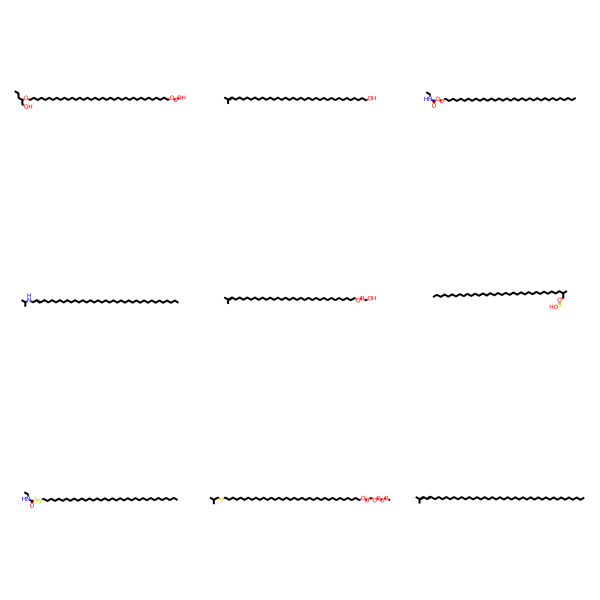

In [504]:
from rdkit.Chem import Draw
#Create mols from smiles
print(valid)
mols = [Chem.MolFromSmiles(smiles) for smiles in right_list]

#Visualize mol
Draw.MolsToGridImage(mols)

In [502]:
data_pre[7141][7]

'CCCCCCCC[Si](C)(C)OC1=CC=CC=C1'

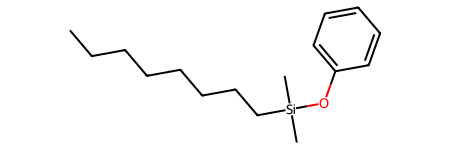

In [488]:
Chem.MolFromSmiles(data_pre[7141][7])